# Proyecto integrador I - Refined
---
Presentado por:
* Karla Orozco
* Jonathan zapata
* Juan Fernando Gallego

---
### Importar librerías y funciones

In [1]:
# %load model_functions.py

import numpy as np
import pandas as pd

#Simular datos usando cholesky
def simulate_data(df, n_simul):
    row,col=df.shape #Dimensiones
    x=df.to_numpy() #Datos como arreglo
    unos=np.ones((row,1)) #Vector de unos
    x_barra=(1/row)*(x.T@unos) #vector de medias
    x_centrado=x-unos@x_barra.T #Matriz de centrado
    sigma=(1/(row-1))*(x_centrado.T@x_centrado) #cov
    try:
        print('trying Usual covariance matrix \n')
        L=np.linalg.cholesky(sigma) #cholesky
        print('Success using usual covariance matriz')
        print('Usual covariance matriz determinant:', np.linalg.det(sigma))
        print('Usual covariance matriz condition number:', np.linalg.cond(sigma), '\n')
    except:
        print('Warning using usual covariance matrix')
        print('Usual covariance matriz determinant:', np.linalg.det(sigma))
        print('Usual covariance matriz condition number:', np.linalg.cond(sigma), '\n')
        print('trying Shrinkage estimator covariance matrix \n')
        eig,vect=np.linalg.eig(sigma)
        i=0
        while np.linalg.det(sigma)<15:
            sigma=sigma+np.eye(col)*(i*abs(min(eig)))
            i+=1
            if i==50:
                break
        #from sklearn.covariance import LedoitWolf
        #sigma=LedoitWolf().fit(x_centrado).covariance_
        L=np.linalg.cholesky(sigma) #cholesky
        print('Success using Shrinkage estimator covariance matriz')
        print('Increasing: '+str(i)+' times min abs eigenvalue, resulting in an increment of : '+str(i*abs(min(eig)))+'\n')
        print('Shrinkage estimator covariance matrix determinant:', np.linalg.det(sigma))
        print('Shrinkage estimator covariance matrix condition number:', np.linalg.cond(sigma), '\n')
    Ruido=np.random.randn(col,n_simul) #Datos ruido blanco
    aux=L@Ruido
    datos=aux.T #datos simulados, no media de originales
    df_datos=pd.DataFrame(datos, columns=df.columns)
    
    row_simul,col_simul=df_datos.shape #Dimensiones
    x_simul = df_datos.to_numpy() #Datos como arreglo
    unos_simul = np.ones((row_simul,1)) #Vector de unos
    x_barra_simul = (1/row_simul)*(x_simul.T@unos_simul)
    
    x_centrado_simul = x_simul - unos_simul@x_barra_simul.T #Matriz de centrado simulada
    datos2 = x_centrado_simul + unos_simul@x_barra.T #Agregar la media de los originales
    df_datos2=pd.DataFrame(datos2, columns=df.columns)
    
    return df_datos2


#Balancear datos por clase
def balance_data(datos, col_cat, n):
    data=datos.copy()
    for i in np.unique(data[col_cat]):
        df=data.loc[data[col_cat]==i].drop(col_cat, axis=1).copy()
        if len(df)>n:
            print('n can´t be less than length of some categorie')
            break
        if len(df)==n:
            pass
        else:
            n_simul=n-len(df)
            df_simul=simulate_data(df, n_simul)
            df_simul[col_cat]=i
            data=data.append(df_simul, ignore_index=True)
    return data


#Método de identificación de datos raros multivariante: proxy
from scipy.stats import kurtosis
import matplotlib.pyplot as plt

#Porcentaje de valores a remover siempre y cuando esten más alejados de los bigotes
porc_remove=.1
#Número de proyecciones a realizar en cada iteración
N=10000

def kur_simul_montecarlo(data_standard, porc_remove=porc_remove, N=N):
    #Cantidad de valores a remover
    remove= int(np.ceil(len(data_standard)*porc_remove))
    print('Cantidad esperada de valores a remover '+str(remove))

    #Iniciar vector de posiciones removidas
    pos_removed=[]
    #Crear serie para extrar el índice de la posición en cada iteración
    #a medida que van saliendo valores
    pos_serie=pd.Series(range(len(data_standard)))

    while len(pos_removed)<remove:
        #Dimensiones de los datos
        row,col=data_standard.shape
        #Vectores de proyección
        V=np.random.randn(col,N)
        #Vectores de proyección normalizados
        u=V/np.linalg.norm(V, axis=0)
        #Proyectar datos
        P=data_standard@u
        #Calcular kurtosis
        K=kurtosis(P, axis=0)
        #vector de máxima kurtosis
        I=np.where(K==max(K))[0][0]
        #proyección de máxima kurtosis
        P_max=data_standard@u[:,I]

        #percentiles extremos
        q1,q3=np.percentile(P_max, [25,75])
        #Rango intercualtilico
        iqr=q3-q1
        #Bigotes
        BS=q3+1.5*iqr
        BI=q1-1.5*iqr

        #vector con las posiciones de los puntos más alejados en P_max
        far=np.where((P_max<BI)|(P_max>BS))[0]
        if len(far)>0:
            #puntos más alejados en P_max, ordenarlos de forma descendente
            points_far=pd.Series(abs(P_max[far]),far).sort_values(ascending=False)
            #posición a remover del valor más alejado de los bigotes
            pos_remove=points_far.iloc[:1].index.values
            #Agregar posición removida en el vector "pos_removed"
            pos_removed.append(pos_serie.index[pos_remove])
            #vector booleano de posiciones a mantener
            bool_to_keep=~np.isin(list(range(row)),pos_remove)
            #Remover valor más alejado de los bigotes
            data_standard=data_standard[bool_to_keep,:]
            pos_serie=pos_serie[bool_to_keep]
        else:
            #Resultado
            print('No hay puntos más alejados de los bigotes.')
            break

    #Resultado
    print('Han sido retirados: '+str(len(pos_removed))+' registros, correspondientes al: '+
          str(round(len(pos_removed)/(row+len(pos_removed))*100,3))+'% de los datos originales.\n')
    #vector booleano de posiciones a mantener
    bool_to_keep=~np.isin(list(range(row)),pos_removed)

    #Mostrar última proyección de máxima curtosis
    fig,ax=plt.subplots()
    plt.boxplot(data_standard@u[:,I])
    
    return data_standard


#kur_simul_montecarlo por clase
from sklearn import preprocessing

def kur_per_class(datos, col_class):
    dt=pd.DataFrame(columns=datos.columns)
    for i in np.unique(datos[col_class]):
        scaler = preprocessing.StandardScaler()
        #Estandarizar los datos a limpiar
        df_standard=scaler.fit_transform(datos.loc[datos[col_class]==i].drop([col_class], axis=1).values)
        #limpiar datos
        df_standard=kur_simul_montecarlo(df_standard)
        #Desestandarizar los datos limpios, sin col_class
        temp=pd.DataFrame(scaler.inverse_transform(df_standard),columns=datos.columns[datos.columns!=col_class])
        #Calcular categoria col_class respectiva
        temp[col_class]=int(i)
        #Concatenarlos
        dt=dt.append(temp, ignore_index=True)
    return dt

---
### Pasos a seguir
1. Cargar datos refinados
2. Retirar datos multivariantes raros por categoría
3. Análisis de correlaciones, retirar variables redundantes
4. Estadísticos y gráficos
5. Balancear clases
6. Dividir los datos en conjunto de entrenamiento y testeo
7. Modelar

---
### 1. Cargar datos refinados

In [2]:
datos_company = pd.read_csv('trusted/data_company/AAPL.csv')

In [3]:
datos_company.drop(['date','Y2'], axis=1, inplace=True)

In [4]:
datos_company.reset_index(drop=True, inplace=True)

In [5]:
datos_company.head()

,sum_eng_negative,sum_eng_neutral,sum_eng_positive,negative,neutral,positive,n_tweets,dispersion_tweets_content,Y
0,93.0,153.0,1453.0,0.103679,0.474916,0.421405,299,0.949833,0
1,128.0,1283.0,962.0,0.168397,0.469435,0.362168,867,0.984757,0
2,5.0,159.0,116.0,0.086705,0.390173,0.523121,346,0.947436,0
3,27.0,156.0,534.0,0.103448,0.396552,0.500000,406,0.956178,0
4,201.0,422.0,528.0,0.163034,0.414124,0.422842,1147,0.981740,0


In [6]:
datos_company.Y.value_counts()

0    1748
1      39
2      32
Name: Y, dtype: int64

---
### 2. Retirar datos multivariantes raros por categoría

#### Método de identificación de datos raros multivariante: proxy

Cantidad esperada de valores a remover 175
Han sido retirados: 175 registros, correspondientes al: 10.006% de los datos originales.

Cantidad esperada de valores a remover 4
Han sido retirados: 4 registros, correspondientes al: 10.0% de los datos originales.

Cantidad esperada de valores a remover 4
Han sido retirados: 4 registros, correspondientes al: 12.121% de los datos originales.



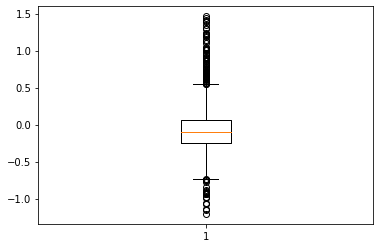

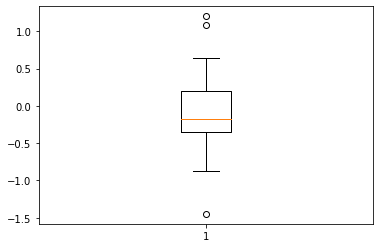

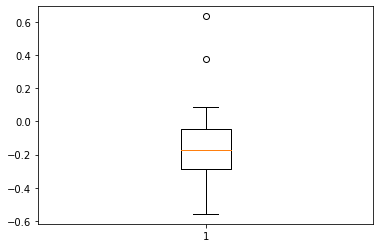

In [7]:
datos_company=kur_per_class(datos_company, 'Y')

In [8]:
datos_company.Y.value_counts()

0    1573
1      35
2      28
Name: Y, dtype: int64

---
### 3. Análisis de correlaciones, retirar variables redundantes

#### Datos X

In [9]:
X=datos_company.drop('Y', axis=1) 

#### Examinar datos X

### Analísis de dependencias líneales

#### Coefciente de correlación

$$r_{ij} = \mbox{coeficiente de correlación lineal de Pearson}$$

Medida de correlación entre pares de variables

In [10]:
import seaborn as sns

<AxesSubplot:>

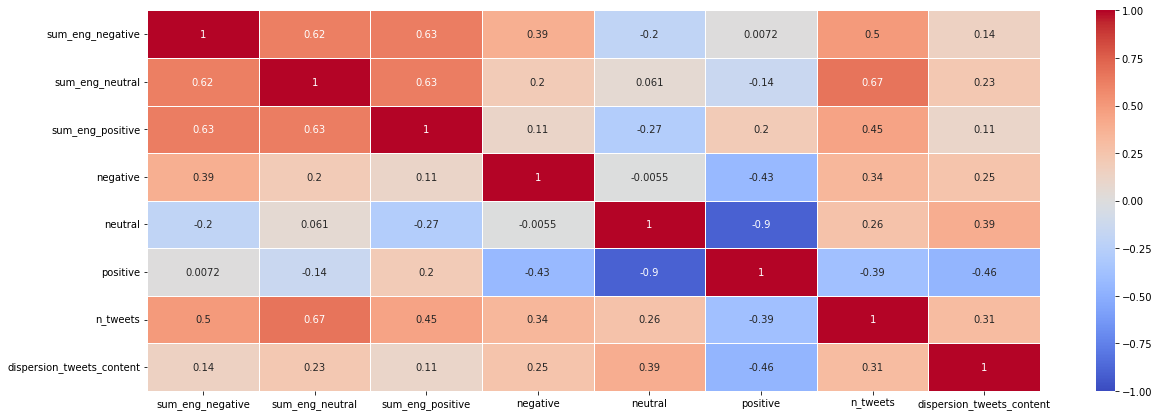

In [11]:
fig, ax = plt.subplots(figsize=(20,7)) #Ajustar ancho y alto del gráfico
sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)

Text(0.5, 1.0, 'neutral vs positive')

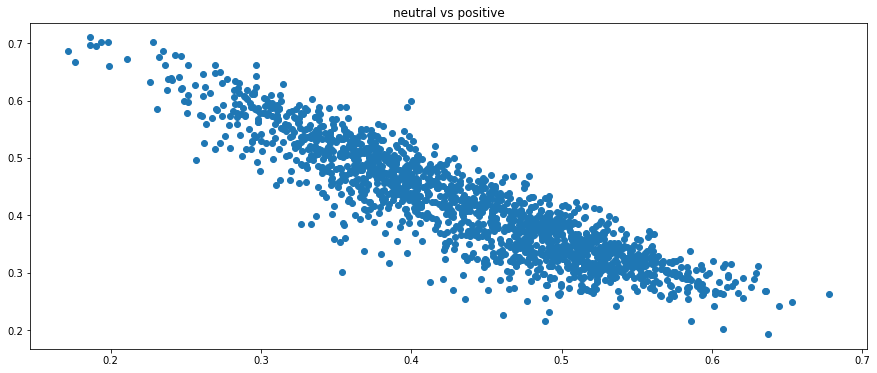

In [12]:
fig, ax = plt.subplots(figsize=(15,6))

ax.plot(X['neutral'], X['positive'], 'o')
ax.set_title('neutral vs positive')

#### Coeficiente de correlación multiple

$$R^2 = 1 - \frac{1}{s_{ii} \; s^{jj}}$$

Indica el grado en el que una variable es predecida por las demás.

In [13]:
#Diagonal de la matriz de covarianzas
Diag_Cov = np.diag(X.cov())
#Diagonal de la matriz de precisión
Diag_Cov_inv = np.diag(np.linalg.inv(X.cov()))
#Realizar calculo
R2 =  1 - 1/(Diag_Cov*Diag_Cov_inv)
#Resultados
pd.Series(R2, X.columns).sort_values(ascending=False)

neutral                      1.000000
positive                     1.000000
negative                     1.000000
sum_eng_neutral              0.625552
sum_eng_negative             0.575875
sum_eng_positive             0.574092
n_tweets                     0.568736
dispersion_tweets_content    0.257970
dtype: float64

##### Retirar variables correlaciones entre sí

In [14]:
X=X.drop(['neutral'], axis=1)
datos_company=datos_company.drop(['neutral'], axis=1)
X.shape

(1636, 7)

##### Recalcular correlación multiple

In [15]:
#Diagonal de la matriz de covarianzas
Diag_Cov = np.diag(X.cov())
#Diagonal de la matriz de precisión
Diag_Cov_inv = np.diag(np.linalg.inv(X.cov()))
#Realizar calculo
R2 =  1 - 1/(Diag_Cov*Diag_Cov_inv)
#Resultados
pd.Series(R2, X.columns).sort_values(ascending=False)

sum_eng_neutral              0.625552
sum_eng_negative             0.575875
sum_eng_positive             0.574092
n_tweets                     0.568736
positive                     0.523143
negative                     0.364875
dispersion_tweets_content    0.257970
dtype: float64

Se aprecia que ninguna variable es muy explicada por las demás.

---
### 4. Estadísticos y gráficos

### Gráficos para identificar relaciones

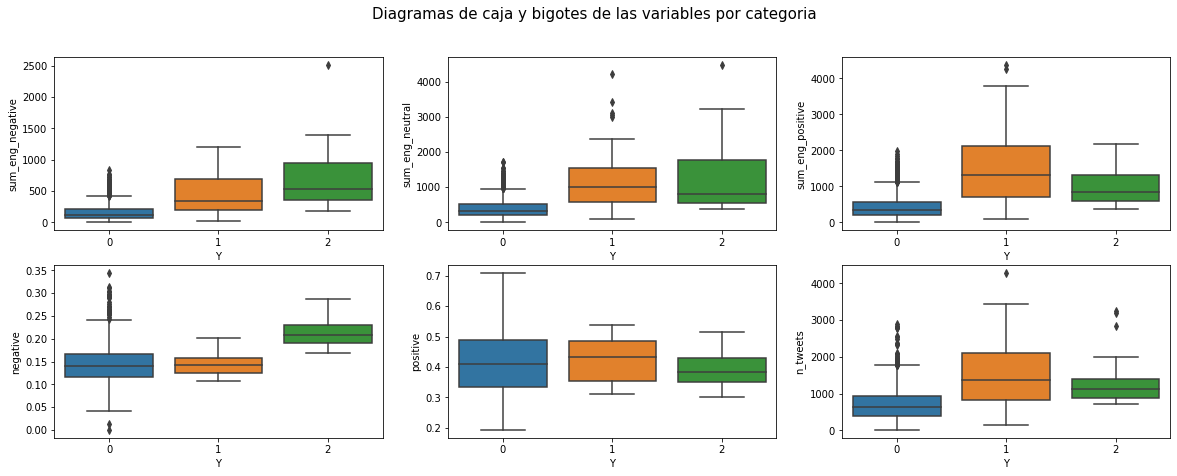

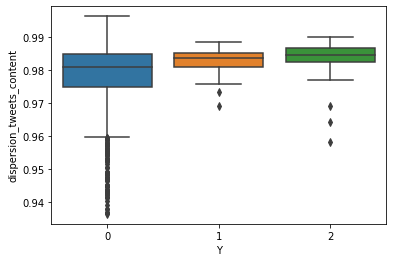

In [16]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6))=plt.subplots(2,3,figsize=(20,7))

temp=datos_company.copy() #Copia temporal de los datos

fig.suptitle('Diagramas de caja y bigotes de las variables por categoria', fontsize=15)

sns.boxplot(x='Y', y='sum_eng_negative', data=temp, ax=ax1)
sns.boxplot(x='Y', y='sum_eng_neutral', data=temp, ax=ax2)
sns.boxplot(x='Y', y='sum_eng_positive', data=temp, ax=ax3)
sns.boxplot(x='Y', y='negative', data=temp, ax=ax4)
sns.boxplot(x='Y', y='positive', data=temp, ax=ax5)
sns.boxplot(x='Y', y='n_tweets', data=temp, ax=ax6)

fig2, ax=plt.subplots()
sns.boxplot(x='Y', y='dispersion_tweets_content', data=temp)

del temp

Media:

In [17]:
datos_company.groupby('Y').mean()

,sum_eng_negative,sum_eng_neutral,sum_eng_positive,negative,positive,n_tweets,dispersion_tweets_content
Y,,,,,,,
0,157.082645,392.019072,435.318500,0.144392,0.417433,703.767959,0.978243
1,439.085714,1297.571429,1512.514286,0.143480,0.425775,1593.171429,0.982438
2,697.678571,1241.857143,975.714286,0.215427,0.397824,1344.000000,0.982602


Mediana:

In [18]:
datos_company.groupby('Y').median()

,sum_eng_negative,sum_eng_neutral,sum_eng_positive,negative,positive,n_tweets,dispersion_tweets_content
Y,,,,,,,
0,119.0,332.0,333.0,0.139423,0.408683,626.0,0.980851
1,335.0,1012.0,1329.0,0.141982,0.431214,1377.0,0.983516
2,527.5,802.5,846.0,0.209231,0.384763,1117.5,0.984486


Desviación estandar:

In [19]:
datos_company.groupby('Y').std()

,sum_eng_negative,sum_eng_neutral,sum_eng_positive,negative,positive,n_tweets,dispersion_tweets_content
Y,,,,,,,
0,131.121909,268.943432,319.805566,0.041805,0.097646,429.058471,0.009607
1,309.291731,1022.571478,1091.725573,0.023522,0.070437,1002.080350,0.004417
2,494.328804,972.694033,463.455128,0.031639,0.063201,692.810166,0.007381


Asimetría:

In [20]:
datos_company.groupby('Y').skew()

,sum_eng_negative,sum_eng_neutral,sum_eng_positive,negative,positive,n_tweets,dispersion_tweets_content
Y,,,,,,,
0,1.653162,1.452917,1.517175,0.692226,0.419062,1.243850,-1.632769
1,0.670221,1.250691,1.104423,0.676154,-0.012772,0.985184,-1.042091
2,2.030573,1.695682,0.746903,0.999903,0.559210,1.871015,-2.190409


Desviación estandar generalizada:

In [21]:
datos_company.groupby('Y').apply(lambda x: np.sqrt(np.linalg.det(x.drop('Y',axis=1).cov())))

Y
0     55228.799939
1    304394.516773
2    198594.420957
dtype: float64

Mediana multivariante:

In [115]:
def multivariate_median(x):
    row,col=x.shape
    I=[]
    for j in range(row):
        I_j=0
        for i in range(row):
            I_j=I_j+np.linalg.norm(x.iloc[j,:]-x.iloc[i,:])
        I.append(I_j)
    minimo=min(I)
    I2=np.where(I==minimo)[0]
    return x.iloc[I2]

In [116]:
datos_company.groupby('Y').apply(lambda x: multivariate_median(x.drop('Y',axis=1)))

,,sum_eng_negative,sum_eng_neutral,sum_eng_positive,negative,positive,n_tweets,dispersion_tweets_content
Y,,,,,,,,
0,1081,189.0,362.0,373.0,0.164852,0.426128,643.0,0.987478
1,1602,394.0,1012.0,1070.0,0.120968,0.531250,992.0,0.973225
2,1627,435.0,885.0,938.0,0.209542,0.415341,1069.0,0.984549


---
### 5. Balancear clases

In [22]:
datos_company.Y.value_counts()

0    1573
1      35
2      28
Name: Y, dtype: int64

In [23]:
#mayor longitud en las clases
max_class_len=np.max(datos_company.Y.value_counts())

In [24]:
max_class_len

1573

In [25]:
datos=balance_data(datos_company, 'Y', max_class_len)

trying Usual covariance matrix 

Success using usual covariance matriz
Usual covariance matriz determinant: 92656021841.46323
Usual covariance matriz condition number: 191488533719.0635 

trying Usual covariance matrix 

Success using usual covariance matriz
Usual covariance matriz determinant: 39439744035.065346
Usual covariance matriz condition number: 70003836735.38553 



In [26]:
datos.Y.value_counts()

0    1573
1    1573
2    1573
Name: Y, dtype: int64

---
### 6. Dividir datos en conjunto de entramiento y testeo

#### Datos modelo X y Y

In [27]:
X=datos.drop('Y', axis=1) 
Y=datos['Y'].astype('int')

#### Transformar los datos X a la misma escala

In [28]:
scaler = preprocessing.StandardScaler()

In [29]:
X_standard=scaler.fit_transform(X.values)

---
#### Dividir los datos en conjunto de entramiento y de testeo

In [30]:
from sklearn.model_selection import train_test_split

Datos balanceados: (original + simulados)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X_standard, Y.values, 
                                                    train_size= 0.70, stratify=Y.values)

Datos desbalanceados: (originales)

In [32]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(scaler.transform(datos_company.loc[:,X.columns].values), 
                                                        datos_company.Y.astype('int').values, 
                                                        train_size= 0.70, stratify=datos_company.Y.astype('int').values)

---
### 7. Modelar

In [33]:
from sklearn.metrics import confusion_matrix

---
#### Realizar regresión logística One vs Rest sklearn

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
model = LogisticRegression(multi_class='ovr')

In [36]:
model.fit(x_train, y_train) #Optimizar el modelo

LogisticRegression(multi_class='ovr')

In [37]:
model.score(x_test, y_test)

0.7796610169491526

In [38]:
ovr_predict=model.predict(x_test)

In [39]:
confusion_matrix(y_true=y_test, y_pred=ovr_predict)

array([[361,  50,  61],
       [110, 350,  12],
       [ 65,  14, 393]], dtype=int64)

Los datos reales son las filas. Los datos estimados son las columnas

##### Evaluar en una muestra de los datos originales

In [40]:
model.score(x_test2, y_test2)

0.7861507128309573

In [41]:
confusion_matrix(y_true=y_test2, y_pred=model.predict(x_test2))

array([[370,  55,  47],
       [  3,   8,   0],
       [  0,   0,   8]], dtype=int64)

---
Opción de que el modelo tenga un rango medio en el que no decide

In [42]:
ovr_eval_predict=model.predict_proba(x_test)
ovr_pos_eval=np.apply_along_axis(np.argmax, 1, ovr_eval_predict)
ovr_max_eval=np.apply_along_axis(np.max, 1, ovr_eval_predict)

In [43]:
ovr_max_eval[(ovr_max_eval<.3)] = ovr_pos_eval[(ovr_max_eval<.3)]
ovr_max_eval[(ovr_max_eval>.7)] = ovr_pos_eval[(ovr_max_eval>.7)]
eval_ovr=np.isin(ovr_max_eval,list(range(ovr_eval_predict.shape[1])))

In [44]:
len(eval_ovr), len(np.where(eval_ovr==True)[0])

(1416, 824)

No responde:

In [45]:
len(eval_ovr)-len(np.where(eval_ovr == True)[0])

592

Precisión en el conjunto de testeo:

In [46]:
sum(ovr_max_eval[eval_ovr] == y_test[eval_ovr])/len(y_test[eval_ovr])

0.883495145631068

In [47]:
pd.DataFrame(y_test[eval_ovr]).value_counts().sort_index()

0    192
1    302
2    330
dtype: int64

In [48]:
pd.DataFrame(ovr_max_eval[eval_ovr]).value_counts().sort_index()

0.0    227
1.0    257
2.0    340
dtype: int64

In [49]:
confusion_matrix(y_true=y_test[eval_ovr], y_pred=ovr_max_eval[eval_ovr])

array([[163,   6,  23],
       [ 50, 250,   2],
       [ 14,   1, 315]], dtype=int64)

Los datos reales son las filas. Los datos estimados son las columnas

---

---
#### KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier

In [51]:
knn = KNeighborsClassifier(n_neighbors=32, weights='distance')

In [52]:
knn.fit(x_train, y_train) #Optimizar el modelo

KNeighborsClassifier(n_neighbors=32, weights='distance')

In [53]:
knn_predict_train = knn.predict(x_train)

In [54]:
sum(knn_predict_train == y_train)/len(y_train)

1.0

In [55]:
knn_predict_test = knn.predict(x_test)

In [56]:
sum(knn_predict_test == y_test)/len(y_test)

0.8594632768361582

In [57]:
confusion_matrix(y_true=y_test, y_pred=knn_predict_test)

array([[433,  24,  15],
       [ 88, 368,  16],
       [ 42,  14, 416]], dtype=int64)

Los datos reales son las filas. Los datos estimados son las columnas

##### Evaluar en una muestra de los datos originales

In [58]:
sum(knn.predict(x_test2) == y_test2)/len(y_test2)

0.9735234215885947

In [59]:
confusion_matrix(y_true=y_test2, y_pred=knn.predict(x_test2))

array([[462,   7,   3],
       [  2,   9,   0],
       [  1,   0,   7]], dtype=int64)

---
Opción de que el modelo tenga un rango medio en el que no decide

In [60]:
eval_knn = np.apply_along_axis(lambda x: any(x >= .7), 1, knn.predict_proba(x_test))

In [61]:
len(eval_knn), len(np.where(eval_knn == True)[0])

(1416, 1112)

No responde:

In [62]:
len(eval_knn)-len(np.where(eval_knn == True)[0])

304

In [63]:
knn_predict_eval = knn.predict(x_test[eval_knn])

In [64]:
sum(knn_predict_eval == y_test[eval_knn])/len(y_test[eval_knn])

0.9361510791366906

In [65]:
pd.DataFrame(y_test[eval_knn]).value_counts().sort_index()

0    399
1    345
2    368
dtype: int64

In [66]:
pd.DataFrame(knn_predict_eval).value_counts().sort_index()

0    437
1    318
2    357
dtype: int64

In [67]:
confusion_matrix(y_true=y_test[eval_knn], y_pred=knn_predict_eval)

array([[385,  10,   4],
       [ 38, 305,   2],
       [ 14,   3, 351]], dtype=int64)

Los datos reales son las filas. Los datos estimados son las columnas

---

---
#### Árbol

In [68]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
arbol = DecisionTreeClassifier(criterion='entropy', max_depth = 8) #, class_weight='balanced'

In [70]:
arbol = arbol.fit(x_train, y_train) #Optimizar el modelo

In [71]:
arbol.score(x_train, y_train)

0.9173478655767484

In [72]:
arbol.score(x_test, y_test)

0.8601694915254238

In [73]:
arbol_predict_test=arbol.predict(x_test)

In [74]:
confusion_matrix(y_true=y_test, y_pred=arbol_predict_test)

array([[425,  34,  13],
       [ 55, 396,  21],
       [ 40,  35, 397]], dtype=int64)

Los datos reales son las filas. Los datos estimados son las columnas

##### Evaluar en una muestra de los datos originales

In [75]:
arbol.score(x_test2, y_test2)

0.9287169042769857

In [76]:
confusion_matrix(y_true=y_test2, y_pred=arbol.predict(x_test2))

array([[442,  23,   7],
       [  3,   7,   1],
       [  1,   0,   7]], dtype=int64)

---
Opción de que el modelo tenga un rango medio en el que no decide

In [77]:
eval_arbol = np.apply_along_axis(lambda x: any(x >= .7), 1, arbol.predict_proba(x_test))

In [78]:
len(eval_arbol), len(np.where(eval_arbol == True)[0])

(1416, 1224)

No responde:

In [79]:
len(eval_arbol)-len(np.where(eval_arbol == True)[0])

192

In [80]:
arbol.score(x_test[eval_arbol], y_test[eval_arbol])

0.9093137254901961

In [81]:
arbol_predict_eval=arbol.predict(x_test[eval_arbol])

In [82]:
pd.DataFrame(y_test[eval_arbol]).value_counts().sort_index()

0    397
1    404
2    423
dtype: int64

In [83]:
pd.DataFrame(arbol_predict_eval).value_counts().sort_index()

0    426
1    385
2    413
dtype: int64

In [84]:
confusion_matrix(y_true=y_test[eval_arbol], y_pred=arbol_predict_eval)

array([[376,  11,  10],
       [ 32, 353,  19],
       [ 18,  21, 384]], dtype=int64)

Los datos reales son las filas. Los datos estimados son las columnas

---

---
Observar árbol:

In [85]:
from sklearn import tree

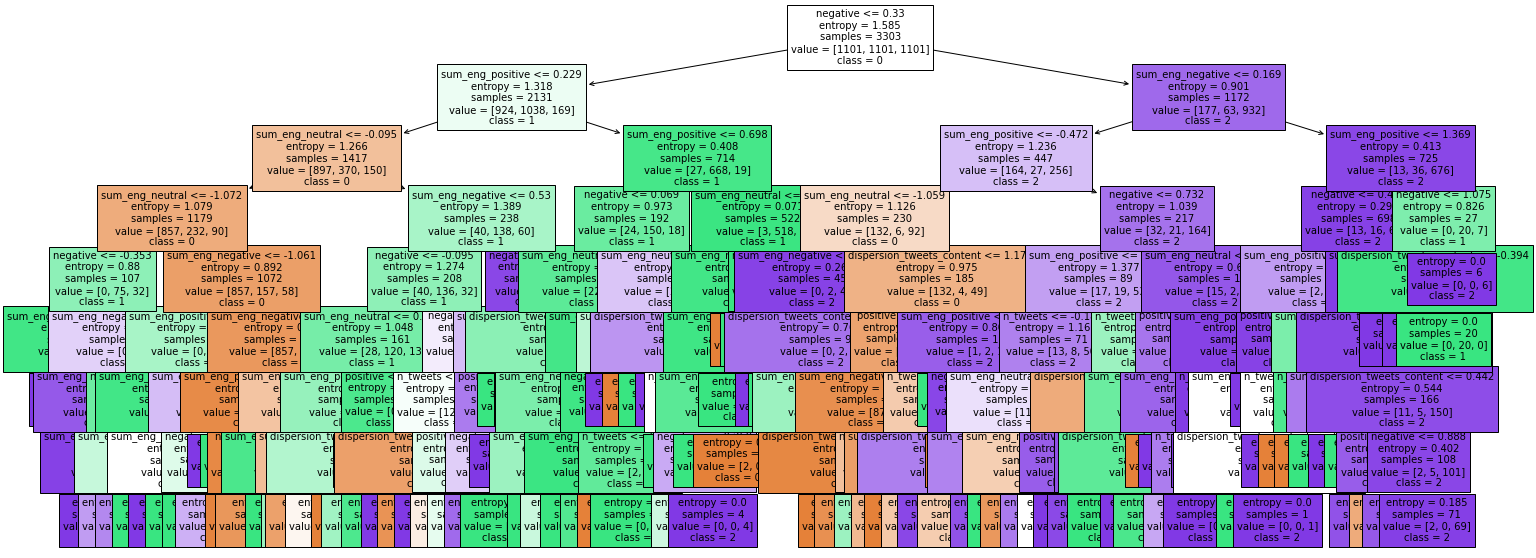

In [86]:
fig = plt.figure(figsize=(25,10)) #Ajustar ancho y alto del gráfico
plt.show(tree.plot_tree(arbol, fontsize=10, feature_names=X.columns, class_names=[str(round(i)) for i in np.unique(y_train)], filled=True))